In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,GRU, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud,STOPWORDS
import string

In [2]:
df=pd.read_csv('nirvana.csv')
df.head()

,title,lyrics
0,About a Girl,"['I need an easy friend', 'I do, with an ear t..."
1,Aero Zeppelin,"[""What's the season of love if you can't have ..."
2,Ain't It A Shame,"[""Ain't it a shame to go fishin on a Sunday"", ..."
3,Alcohol (High On The Hog),"['My baby taught me how to live', 'My baby tau..."
4,All Apologies,"['What else should I be?', 'All apologies', 'W..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   143 non-null    object
 1   lyrics  143 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [4]:
lyrics=""
for i in df['lyrics']:
    lyrics=lyrics+ i
print(lyrics)

['I need an easy friend', 'I do, with an ear to lend', 'I do, think you fit this shoe', 'I do, but you have a clue', "I'll take advantage while", 'You hang me out to dry', "But I can't see you every night", 'Free, I do', "I'm standing in your line", 'I do, hope you have the time', 'I do, pick a number too', 'I do, keep a date with you', "I'll take advantage while", 'You hang me out to dry', "But I can't see you every night", 'Free', 'I need an easy friend', 'I do, with an ear to lend', 'I do, think you fit this shoe', "I do, won't you have a clue", "I'll take advantage while", 'You hang me out to dry', "But I can't see you every night", 'No I can see you every night', 'Free', 'I do, I do, I do, I do']["What's the season of love if you can't have everything", "What's the reason of love if you can lose everything", "What's the meaning of love, it's a crime if anything", "What's the meaning of love, it's a crime, it's a crime", "How can a culture can forget it's plan of yesterday", "And y

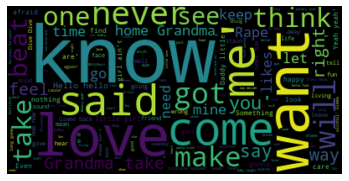

In [5]:
stopwords=set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(lyrics)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [6]:
tokenizer=Tokenizer()
corpus=lyrics.lower().split('\n')
tokenizer.fit_on_texts(corpus)
total_words=len(tokenizer.word_index)+1
print(total_words)

3372


In [7]:
input_sequences=[]
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range (1,len(token_list)):
        n_gram_seqeuence = token_list[:i+1]
        input_sequences.append(n_gram_seqeuence)

In [8]:
max_sequence_len=max([len(x) for x in input_sequences])
input_sequences=np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))

In [9]:
xs=input_sequences[:,:-1]
labels=input_sequences[:,-1]

In [10]:
ys = tf.keras.utils.to_categorical(labels,num_classes=total_words)

In [ ]:
model=Sequential()
model.add(Embedding(total_words,240,input_length=max_sequence_len-1))
model.add(LSTM(150,return_sequences=True))
model.add(GRU(50))
model.add(Dense(total_words,activation='softmax'))
adam=Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
early_stop = EarlyStopping(monitor='loss', patience=3)
history=model.fit(xs,ys,epochs=150,verbose=1)

Epoch 1/150


In [ ]:
seed_text='It\'s so soothing'
next_words=20
for _ in range(next_words):
    token_list=tokenizer.texts_tov_sequences([seed_text])[0]
    token_list=pad_sequences([token_list],maxlen=max_sequence_len-1,padding='pre')
    predicted=model.predict_classes(token_list, verbose=0)
    output_word=''
    for word,index in tokenizer.word_index.items():
        if index==predicted:
            output_word=word
            break
        seed_text=" " + output_word
    print(seed_text)